In [1]:
!pip install "dask[complete]"
!pip install pyarrow pandas

In [2]:
!pip install hdbscan


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import hdbscan
from sklearn.metrics import recall_score, precision_score, accuracy_score, classification_report
import time
import pandas as pd
import dask.dataframe as dd
import glob
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.spatial.distance import cdist
from warnings import filterwarnings
filterwarnings('ignore')


In [5]:
# 1. Load Data from Parquet Files
data_dir = '/content/drive/MyDrive/Data_hasking'
# Get a list of all parquet files (first 20 days) and load them into a Dask DataFrame
file_list = sorted(glob.glob(f"{data_dir}/*.parquet"))[:40]
ddf = dd.read_parquet(file_list)
# Compute the Dask DataFrame into a Pandas DataFrame
# df = ddf.compute()

In [6]:
# 2. Load Customer Data
tb_customers = dd.read_parquet('/content/drive/MyDrive/TB_CUSTOMERS.parquet')
tb_customers_df = tb_customers.compute()

# Filter individual customers (CUSTOMER_TYPE == 'Cá nhân')
tb_customers_individual_df = tb_customers_df[tb_customers_df["CUSTOMER_TYPE"] == "Cá nhân"]
individual_customers = tb_customers_individual_df["CUST_CUSTNO"].unique().tolist()


In [7]:
# 3. Filter Transactions for Individual Customers
# df_individual = df[df['CUST_CUSTNO'].isin(individual_customers)]
ddf_filtered = ddf[['CUST_CUSTNO', 'AMOUNT',  'VALUEDATE']]
df_individual = ddf_filtered[ddf_filtered['CUST_CUSTNO'].isin(individual_customers)]
df_individual_df = df_individual.compute()

In [24]:
# 4. Convert VALUEDATE to Datetime and Extract Date
df_individual_df['VALUEDATE'] = pd.to_datetime(df_individual_df['VALUEDATE'], errors='coerce')
df_individual_df['DATE_ONLY'] = df_individual_df['VALUEDATE'].dt.date

In [25]:
df_individual_df

,CUST_CUSTNO,AMOUNT,VALUEDATE,DATE_ONLY
0,a168d638771f6240e978956399d9f16621b02655b20ae8...,-9600.00,2023-08-01,2023-08-01
1,4fd201b58b6b81ad3366160ff82f3d53f622e0290a57db...,-100.00,2023-08-01,2023-08-01
2,52dcdc6af49899ae1dfae36d4eee1625fe717ac6897c2b...,-99.20,2023-08-01,2023-08-01
3,db34f14574441e3f42d7ea1d5299204ea481f9ac8f5ff5...,-120.00,2023-08-01,2023-08-01
4,49454b2d0968a2714066486a540ac8f0a57ee432cc3ca4...,-120.00,2023-08-01,2023-08-01
...,...,...,...,...
623550,b7a87502f6fc0186f4121a76a9780cb36b693e1582b8ab...,100000.00,2023-09-09,2023-09-09
623551,6e9f203c3dc24face6bff660ee9b32b7ea16d0efb9dfe1...,70267.53,2023-09-09,2023-09-09
623552,64b35de667d8ce5291f80e98f3da63931855d251eb8cb2...,52394.52,2023-09-09,2023-09-09
623553,27be2fbe7acca08d73d7160716dd1ae073a22ff06d6038...,41294.16,2023-09-09,2023-09-09


,CUST_CUSTNO,AMOUNT,VALUEDATE,DATE_ONLY
0,a168d638771f6240e978956399d9f16621b02655b20ae8...,-9600.00,2023-08-01,2023-08-01
1,4fd201b58b6b81ad3366160ff82f3d53f622e0290a57db...,-100.00,2023-08-01,2023-08-01
2,52dcdc6af49899ae1dfae36d4eee1625fe717ac6897c2b...,-99.20,2023-08-01,2023-08-01
3,db34f14574441e3f42d7ea1d5299204ea481f9ac8f5ff5...,-120.00,2023-08-01,2023-08-01
4,49454b2d0968a2714066486a540ac8f0a57ee432cc3ca4...,-120.00,2023-08-01,2023-08-01
...,...,...,...,...
623550,b7a87502f6fc0186f4121a76a9780cb36b693e1582b8ab...,100000.00,2023-09-09,2023-09-09
623551,6e9f203c3dc24face6bff660ee9b32b7ea16d0efb9dfe1...,70267.53,2023-09-09,2023-09-09
623552,64b35de667d8ce5291f80e98f3da63931855d251eb8cb2...,52394.52,2023-09-09,2023-09-09
623553,27be2fbe7acca08d73d7160716dd1ae073a22ff06d6038...,41294.16,2023-09-09,2023-09-09


In [26]:
 # 5. Separate Deposits and Withdrawals
df_deposits = df_individual_df[df_individual_df['AMOUNT'] > 0]
df_withdrawals = df_individual_df[df_individual_df['AMOUNT'] < 0]

In [27]:
# 6. Aggregate by Customer and Date
daily_deposits = df_deposits.groupby(['CUST_CUSTNO', 'DATE_ONLY'])['AMOUNT'].sum().reset_index(name='total_deposits')
daily_withdrawals = df_withdrawals.groupby(['CUST_CUSTNO', 'DATE_ONLY'])['AMOUNT'].sum().reset_index(name='total_withdrawals')

In [28]:
# 7. Merge Deposits and Withdrawals Data
transactions = pd.merge(daily_deposits, daily_withdrawals, on=['CUST_CUSTNO', 'DATE_ONLY'], how='outer')

In [29]:
# Fill missing values (no deposits/withdrawals) with 0
transactions['total_deposits'].fillna(0, inplace=True)
transactions['total_withdrawals'].fillna(0, inplace=True)

In [30]:
# 8. Log Transform the Data
transactions['log_total_deposits'] = np.log1p(transactions['total_deposits'])
transactions['log_total_withdrawals'] = np.log1p(transactions['total_withdrawals'].abs())

In [31]:
# 9. Apply Rule 15 Conditions (Anomaly Labeling based on Rule 15)
rule_15_anomalies = transactions[
    (transactions['total_deposits'] >= 6000000) &
    (transactions['total_withdrawals'].abs() >= 0.95 * transactions['total_deposits'])
]
transactions['rule_15_anomaly'] = 0
transactions.loc[rule_15_anomalies.index, 'rule_15_anomaly'] = 1

In [32]:
# 10. Prepare the Data for HDBSCAN
# We will use log-transformed features for clustering
features = transactions[['log_total_deposits', 'log_total_withdrawals']].values
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

In [33]:
# 11. Apply HDBSCAN
clusterer = hdbscan.HDBSCAN(min_cluster_size=30, min_samples=500)
labels = clusterer.fit_predict(scaled_features)


In [34]:
# Add HDBSCAN cluster labels to the dataframe
transactions['cluster'] = labels

In [35]:
# 12. Label anomalies detected by HDBSCAN (-1 indicates an anomaly in HDBSCAN)
transactions['hdbscan_anomaly'] = (transactions['cluster'] == -1).astype(int)


In [40]:

# 13. Evaluate Performance: Compare HDBSCAN Anomalies with Rule 15 Anomalies
y_true = transactions['rule_15_anomaly']
y_pred = transactions['hdbscan_anomaly']

# Calculate recall, precision, and other metrics
recall = recall_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
accuracy = accuracy_score(y_true, y_pred)

# Print the evaluation metrics
print(f"Recall: {recall}")
print(f"Precision: {precision}")
print(f"Accuracy: {accuracy}")
print("\nClassification Report:\n", classification_report(y_true, y_pred))



Recall: 0.8147856861974047
Precision: 0.0019518315848175386
Accuracy: 0.6540737306750332

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.65      0.79   6123191
           1       0.00      0.81      0.00      5086

    accuracy                           0.65   6128277
   macro avg       0.50      0.73      0.40   6128277
weighted avg       1.00      0.65      0.79   6128277



In [41]:
outlier_scores = clusterer.outlier_scores_

In [42]:
transactions['GLOSH_score'] = outlier_scores

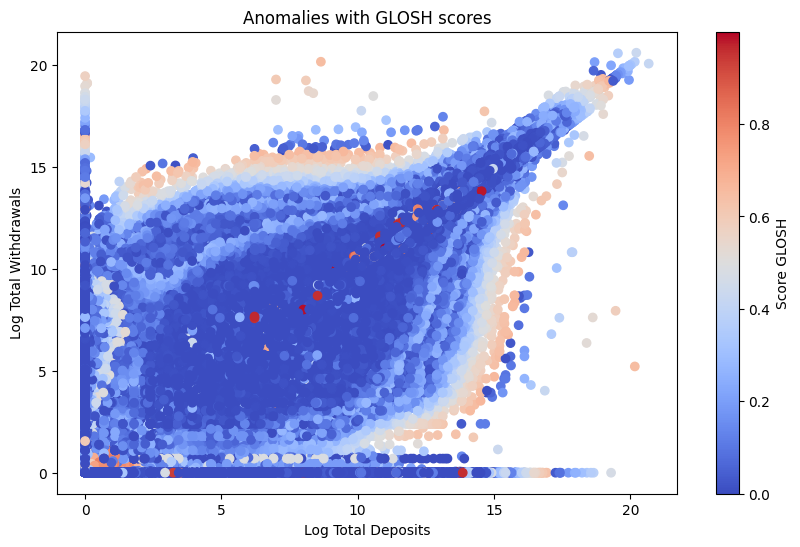

In [43]:
plt.figure(figsize=(10, 6))
plt.scatter(transactions['log_total_deposits'], transactions['log_total_withdrawals'], c=transactions['GLOSH_score'], cmap='coolwarm', label='GLOSH score')
plt.colorbar(label='Score GLOSH')
plt.title('Anomalies with GLOSH scores')
plt.xlabel('Log Total Deposits')
plt.ylabel('Log Total Withdrawals')
plt.show()
